In [15]:
# Создание оригинальной реализации HOG (Histogram of Oriented Gradients)
# Код предназначен для запуска в Jupyter Notebook. Выведет визуализацию HOG и вектор признаков.
# Авторская (не копипаст) реализация: вычисление градиентов, разбиение на ячейки, гистограммы направлений,
# нормализация блоков (L2-Hys), опциональная визуализация (линии в центрах ячеек).
#
# Использование:
# - Скопируйте этот блок в ячейку Jupyter и выполните.
# - Для использования со своим изображением замените `test_img` на загрузку через PIL.Image.open(...) или skimage.io.imread(...).

import numpy as np
import matplotlib.pyplot as plt
from PIL import Image, ImageDraw, ImageFont

In [16]:

def _convert_to_gray(img):
    """Приводит изображение к плавающей шкале [0,1] (серое)"""
    img = np.asarray(img)
    if img.ndim == 3:
        # RGB -> Y (luminance) простым взвешенным суммированием
        r, g, b = img[...,0], img[...,1], img[...,2]
        gray = 0.299*r + 0.587*g + 0.114*b
    else:
        gray = img.astype(float)
    # нормализация
    if gray.max() > 1.0:
        gray = gray / 255.0
    return gray.astype(np.float32)

In [17]:

def _sobel_gradients(img):
    """Возвращает градиенты gx, gy, а также magnitude и orientation (в градусах 0-180 unsigned)"""
    # Простейшие ядра Собеля
    Kx = np.array([[ -1, 0, 1],
                   [ -2, 0, 2],
                   [ -1, 0, 1]], dtype=float)
    Ky = Kx.T * -1.0
    # Свёртка: используем простую реализацию (без scipy), с отступом 1
    h, w = img.shape
    gx = np.zeros_like(img)
    gy = np.zeros_like(img)
    # pad зеркально чтобы границы не обрезать слишком сильно
    pad = 1
    padded = np.pad(img, pad, mode='reflect')
    for i in range(h):
        for j in range(w):
            region = padded[i:i+3, j:j+3]
            gx[i,j] = np.sum(region * Kx)
            gy[i,j] = np.sum(region * Ky)
    magnitude = np.hypot(gx, gy)
    # ориентация в градусах, привязываем к диапазону [0,180)
    orientation = (np.degrees(np.arctan2(gy, gx)) + 180) % 180
    return gx, gy, magnitude, orientation

In [18]:

def _cell_histograms(magnitude, orientation, pixels_per_cell=(8,8), orientations=9):
    """Разбивает на клетки и считает гистограммы направлений для каждой клетки.
       Возвращает массив shape = (n_cells_y, n_cells_x, orientations)"""
    cell_h, cell_w = pixels_per_cell
    h, w = magnitude.shape
    n_cells_y = h // cell_h
    n_cells_x = w // cell_w
    # усечение изображения до целых клеток
    mag = magnitude[:n_cells_y*cell_h, :n_cells_x*cell_w]
    ori = orientation[:n_cells_y*cell_h, :n_cells_x*cell_w]
    # reshape в блоки (cell_h, n_cells_y, cell_w, n_cells_x) потом свести
    mag_cells = mag.reshape(n_cells_y, cell_h, n_cells_x, cell_w).transpose(0,2,1,3)
    ori_cells = ori.reshape(n_cells_y, cell_h, n_cells_x, cell_w).transpose(0,2,1,3)
    # подготовка бинов
    bin_width = 180.0 / orientations
    bins = np.arange(0, 180, bin_width)  # левый край каждого бина
    hist = np.zeros((n_cells_y, n_cells_x, orientations), dtype=float)
    # для каждого бина аккумулируем вклады, используя простую линейную интерполяцию между соседними бинами
    for by in range(n_cells_y):
        for bx in range(n_cells_x):
            cell_m = mag_cells[by, bx].ravel()
            cell_o = ori_cells[by, bx].ravel()
            # нормируем ориентации в индекс и доли для линейной интерполяции
            # float bin index: pos в [0, orientations)
            bin_pos = cell_o / bin_width
            lower = np.floor(bin_pos).astype(int) % orientations
            upper = (lower + 1) % orientations
            upper_weight = bin_pos - np.floor(bin_pos)
            lower_weight = 1.0 - upper_weight
            # аккумулируем
            for k in range(len(cell_m)):
                mag_val = cell_m[k]
                hist[by, bx, lower[k]] += mag_val * lower_weight[k]
                hist[by, bx, upper[k]] += mag_val * upper_weight[k]
    return hist

In [19]:

def _normalize_blocks(cell_hist, cells_per_block=(2,2), eps=1e-5, clip=0.2):
    """Нормализация блоков: L2-Hys (L2-norm + clipping + re-normalize)"""
    n_y, n_x, n_bins = cell_hist.shape
    by, bx = cells_per_block
    # количество блоков по осям (скользящее окно)
    n_blocks_y = n_y - by + 1
    n_blocks_x = n_x - bx + 1
    features = []
    # формируем визуализационный массив (нормированные векторы для каждого блока) для возможного обратного преобразования
    for i in range(n_blocks_y):
        for j in range(n_blocks_x):
            block = cell_hist[i:i+by, j:j+bx].ravel()  # вектор блока
            # L2-нормализация
            norm = np.sqrt(np.sum(block**2) + eps**2)
            v = block / norm
            # clip (L2-Hys)
            v = np.minimum(v, clip)
            # повторная нормализация
            norm2 = np.sqrt(np.sum(v**2) + eps**2)
            v = v / norm2
            features.append(v)
    if len(features) == 0:
        return np.array([])
    return np.concatenate(features)

In [20]:

def hog_descriptor(image, pixels_per_cell=(8,8), cells_per_block=(2,2), orientations=9, visualize=True):
    """
    Основная функция HOG.
    Возвращает (feature_vector, hog_image) если visualize=True, иначе только feature_vector.
    """
    gray = _convert_to_gray(image)
    gx, gy, magnitude, orientation = _sobel_gradients(gray)
    cell_hist = _cell_histograms(magnitude, orientation, pixels_per_cell, orientations)
    feature_vector = _normalize_blocks(cell_hist, cells_per_block)
    if not visualize:
        return feature_vector
        # Построение визуализации HOG как векторного поля
    n_cells_y, n_cells_x, n_bins = cell_hist.shape
    cell_h, cell_w = pixels_per_cell
    max_val = cell_hist.max() if cell_hist.max() != 0 else 1.0

    fig, ax = plt.subplots(1, 2, figsize=(12, 5))
    ax[0].imshow(gray, cmap='gray')
    ax[0].set_title("Исходное (серое) изображение")
    ax[0].axis('off')

    ax[1].imshow(gray, cmap='gray')
    ax[1].set_title("HOG векторное поле")
    ax[1].axis('off')

    bin_width = 180.0 / n_bins
    # Для каждого центра клетки берём доминирующее направление (максимум гистограммы)
    for y in range(n_cells_y):
        for x in range(n_cells_x):
            hist = cell_hist[y, x] / max_val
            best_bin = np.argmax(hist)
            angle_deg = best_bin * bin_width + bin_width / 2.0
            magnitude = hist[best_bin]

            # направление в радианах
            angle_rad = np.deg2rad(angle_deg)
            dx = magnitude * np.cos(angle_rad)
            dy = magnitude * np.sin(angle_rad)

            center_x = x * cell_w + cell_w / 2.0
            center_y = y * cell_h + cell_h / 2.0

            # рисуем стрелку
            ax[1].arrow(center_x, center_y, dx * cell_w / 2, -dy * cell_h / 2,
                        head_width=1.5, head_length=2, fc='red', ec='red')

    plt.tight_layout()
    return feature_vector, fig


/var/folders/fv/fkgvl7hn62s6x3tj0f869w680000gn/T/ipykernel_13407/463008514.py:7: UserWarning: FigureCanvasAgg is non-interactive, and thus cannot be shown
  fig.show()


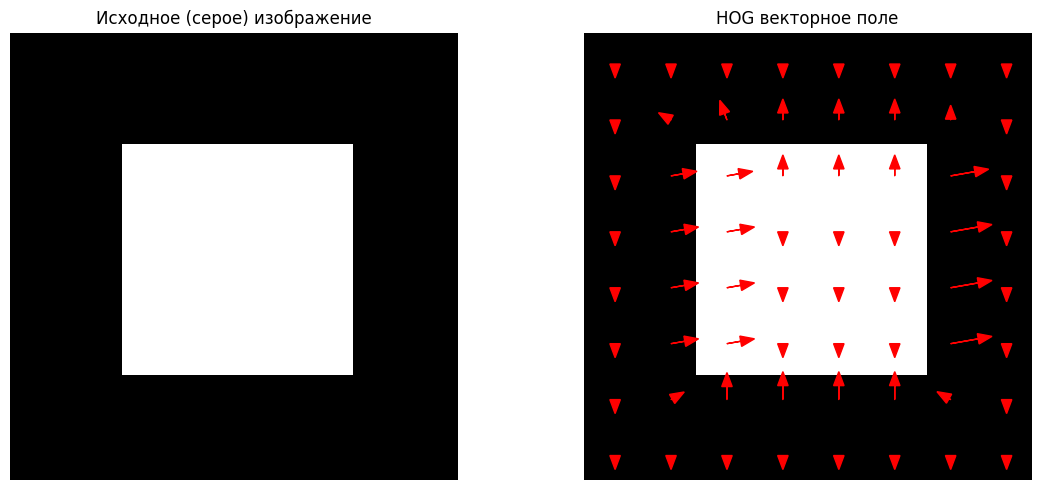

In [21]:

# ------------------ Тестирование на синтетическом изображении ------------------
# Создадим простое изображение: градиент + прямоугольник, чтобы видеть направленные градиенты
img = Image.new('L', (64,64), color=128)
draw = ImageDraw.Draw(img)
draw.rectangle([16, 16, 48, 48], fill=255)
features, fig = hog_descriptor(img, visualize=True)
fig.show()



